TODO

成交量 / TR

# Init

In [1]:
from analysis_utils import *
from plot import PricePlot
from utils import *

import pandas as pd
import numpy as np
from enum import Enum, auto
from typing import Dict, Optional, List, Set, TypeVar, Generic, Callable
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

pd.set_option('display.max_columns', None)

<Figure size 1000x500 with 0 Axes>

In [2]:
usd_name = 'BUSD'
token_name='BTC'
symbol = token_name + usd_name

full_data = get_combined_data(symbol, 'default', 1652229060000, 1658229059999)

# 达到上一顶（底）价格后短期走势

## 后续一段时间最大最小值

In [3]:
# 增加一段时间后的最大值与最小值以及索引
# 如 1,5,3,2，window 为 3，则从 1 开始的三个最大值是 5，索引为0，最小值为2，索引为2
def calc_max_min_window(df: pd.DataFrame, window):
    highs = []
    lows = []
    def calc_max_min(x):
        if len(highs) < window-1:
            highs.append(x['high'])
            lows.append(x['low'])
            max_value = np.nan
            min_value = np.nan
            max_index = np.nan
            min_index = np.nan            

        else:
            highs.append(x['high'])
            lows.append(x['low'])

            max_value = max(highs)
            min_value = min(lows)
            max_index = highs.index(max_value)
            min_index = lows.index(min_value)
            
            highs.pop(0)
            lows.pop(0)

        return pd.Series([max_value, min_value, max_index, min_index])
        
    # df[[max_win, min_win, imax_win, imin_win]] = \
    return df.apply(calc_max_min, axis=1, result_type="expand").shift(-window)

# 将结果合并到原始 DataFrame 中
# df[['max', 'max_index', 'min', 'min_index']] = result
 # 示例数据
test_data = {'high': [1, 5, 3, 2, 3, 5], 'low': [1, 5, 3, 2, 3, 5]}
test_df = pd.DataFrame(test_data)
print(test_df)
print(calc_max_min_window(test_df, 3))
# test_df

   high  low
0     1    1
1     5    5
2     3    3
3     2    2
4     3    3
5     5    5
     0    1    2    3
0  5.0  2.0  0.0  2.0
1  3.0  2.0  0.0  1.0
2  5.0  2.0  2.0  0.0
3  NaN  NaN  NaN  NaN
4  NaN  NaN  NaN  NaN
5  NaN  NaN  NaN  NaN


In [4]:
def add_window_feature(data: FeatData, window):
    names = [f'max_after_{window}', f'min_after_{window}', f'imax_after_{window}', f'imin_after_{window}']
    ftypes = [FeatTypes.PRICE, FeatTypes.PRICE, FeatTypes.OTHERS, FeatTypes.OTHERS]
    data.add_features(names, ftypes, lambda df: calc_max_min_window(df, window))
    return names

# data = FeatData(df, Target(300, [10, 300]))
# add_window_feature(data, 3)
# data.df.tail()

## 获得突破数据

In [45]:
target = Target(target_step=10)
data_top_bottom = FeatData(full_data, target)

# Drop useless features
data_top_bottom.drop_features(
   ['close_time', 'volume', 'taker_buy_volume', 'open_time', 'buy_price', 'sell_price'])


# Add features
add_ave_features(data_top_bottom, cycles = [10, 60, 300], feat_names=['close', 'TR', 'quote_assert_volume', 'number_of_trades'])

add_macd(data_top_bottom, 'close', FeatTypes.DPRICE)
add_macd(data_top_bottom, 'TR', FeatTypes.TR)

# # Drop non price features
# vol_cols = data_top_bottom.cols_of_features([FeatTypes.VOLUME])
# trade_num_cols = data_top_bottom.cols_of_features([FeatTypes.TRADE_NUM])
# data_top_bottom.drop_features(vol_cols + trade_num_cols)

# Select first buy data.
# Note this must after drop non price features (or this feature will be droped) 
# and before drop na (or nan buy_price will be droped)
last_point_traded = False
last_point = 0

def get_first_break(x: pd.DataFrame, point='last_top'):
   global last_point_traded, last_point
   is_traded = False
   if x[point] != last_point:
      last_point = x[point]
      last_point_traded = False
   
   if (last_point_traded == False and 
       (('top' in point and x['high'] >= last_point) or 
        ('bottom' in point and x['low'] <= last_point))
   ):
      is_traded = True
      last_point_traded = True
   
   return is_traded
   
data_top_bottom.add_feature('first_buy', FeatTypes.OTHERS, lambda df: 
                           df.apply(lambda x: get_first_break(x, 'last_top'), axis=1))

data_top_bottom.add_feature('first_sell', FeatTypes.OTHERS, lambda df: 
                           df.apply(lambda x: get_first_break(x, 'last_bottom'), axis=1))

# Add max and min in 10 steps and max_first
window = 10
max_win, min_win, imax_win, imin_win = add_window_feature(data_top_bottom, window)
window = 100
max_100, min_100, imax_100, imin_100 = add_window_feature(data_top_bottom, window)

# Standardization
data_top_bottom.std()

# Drop na at last
data_top_bottom.drop_na()

buy_break_data = data_top_bottom.df[data_top_bottom.df['first_buy']].copy()
drop_col(buy_break_data, ['first_buy', 'first_sell'])

sell_break_data = data_top_bottom.df[data_top_bottom.df['first_sell']].copy()
drop_col(sell_break_data, ['first_buy', 'first_sell'])

sell_break_data.head()

,open,high,low,taker_buy_quote_asset_volume,TR,last_top,step_after_top,last_bottom,step_after_bottom,is_up,cycle_step,earn_after_1,earn_after_3,earn_after_5,earn_after_10,earn_after_30,earn_after_100,earn_after_300,MA10,MA60,MA300,ATR10,ATR60,ATR300,AQAV10,AQAV60,AQAV300,AT10,AT60,AT300,MACD_close,signal_close,histogram_close,MACD_TR,signal_TR,histogram_TR,max_after_10,min_after_10,imax_after_10,imin_after_10,max_after_100,min_after_100,imax_after_100,imin_after_100
371,1.004622,1.004993,0.999997,0.387674,0.004996,1.029207,90.0,1.002062,114.0,0.0,24.0,0.000216,-0.003283,-0.002908,-0.009270,-0.017420,-0.003689,0.019840,1.008571,1.012525,1.009188,0.001852,0.001644,0.001797,0.493015,0.401540,0.451078,0.381740,0.307210,0.343047,-0.001970,-0.001118,-0.000851,0.000399,0.000028,0.000371,1.001197,0.990688,0.0,6.0,1.001197,0.974101,0.0,55.0
631,1.001822,1.002198,0.999829,0.437272,0.002369,1.015675,50.0,1.000035,32.0,1.0,18.0,-0.002138,-0.005821,-0.001747,0.004242,-0.001532,-0.051591,-0.018647,1.005756,1.004029,0.982987,0.002406,0.002529,0.002692,0.951869,0.845139,0.939509,0.768068,0.789652,0.879674,-0.000161,0.000656,-0.000817,-0.000014,-0.000004,-0.000009,1.005177,0.993307,9.0,2.0,1.006879,0.946255,11.0,99.0
684,1.000073,1.000718,0.999714,0.628140,0.001004,1.013395,41.0,0.999736,50.0,0.0,9.0,0.000852,0.000703,-0.000537,0.004231,0.003671,-0.058149,-0.038924,1.001436,1.005912,0.991723,0.001560,0.002085,0.002781,1.266815,1.515955,2.276531,1.123592,1.354020,1.961227,-0.001537,-0.001313,-0.000224,-0.000198,-0.000133,-0.000065,1.005471,0.998805,9.0,4.0,1.009263,0.919990,13.0,55.0
938,1.006519,1.006519,0.999288,0.354559,0.007231,1.043770,83.0,1.001577,118.0,0.0,35.0,-0.003686,0.001371,0.000839,-0.004038,-0.001005,-0.027617,-0.068707,1.008435,1.015968,1.010612,0.004462,0.003788,0.004991,0.426752,0.470877,0.870826,0.470108,0.479456,0.790494,-0.002700,-0.002347,-0.000353,0.000165,0.000136,0.000029,1.004045,0.994852,2.0,1.0,1.008311,0.958117,15.0,96.0
1124,1.002796,1.003119,0.999140,0.418203,0.003979,1.018419,31.0,1.000297,77.0,0.0,46.0,0.002998,0.005119,0.002266,-0.002489,-0.012356,-0.043222,-0.010437,1.006292,1.009228,1.030009,0.003379,0.003510,0.004127,0.603960,0.860897,1.141937,0.637328,0.783385,1.006989,-0.001123,-0.000723,-0.000400,0.000042,-0.000072,0.000114,1.008697,0.995532,3.0,8.0,1.008697,0.954505,3.0,99.0


In [6]:
print_data = buy_break_data.iloc[:]

print(f"buy break num: {len(print_data)}")
print("Earn after buy:")
for step in target.steps:
    print(f"{step}: earn rate: {sum(print_data[target.name(step)] > 0) / len(print_data) * 100 :.2f} %, " + 
          f"mean of earn: {print_data[target.name(step)].mean() * 100 :.2f}%")

print_data = sell_break_data.iloc[:]

print()
print(f"sell break num: {len(print_data)}")
print("Earn after sell:")
for step in target.steps:
    print(f"{step}: earn rate: {sum(print_data[target.name(step)] > 0) / len(print_data) * 100 :.2f} %, " + 
          f"mean of earn: {print_data[target.name(step)].mean() * 100 :.2f}%")
    
# buy_break_data.head(10)

buy break num: 579
Earn after buy:
1: earn rate: 47.15 %, mean of earn: 0.01%
3: earn rate: 41.28 %, mean of earn: -0.01%
5: earn rate: 43.18 %, mean of earn: -0.01%
10: earn rate: 43.01 %, mean of earn: -0.03%
30: earn rate: 45.77 %, mean of earn: -0.02%
100: earn rate: 46.63 %, mean of earn: -0.01%
300: earn rate: 46.80 %, mean of earn: -0.12%

sell break num: 586
Earn after sell:
1: earn rate: 49.15 %, mean of earn: -0.03%
3: earn rate: 50.34 %, mean of earn: -0.03%
5: earn rate: 49.49 %, mean of earn: -0.03%
10: earn rate: 52.39 %, mean of earn: -0.02%
30: earn rate: 49.32 %, mean of earn: -0.06%
100: earn rate: 50.34 %, mean of earn: -0.09%
300: earn rate: 51.71 %, mean of earn: -0.08%


## 统计突破高点后一段时间的最高、最低值

### 概述

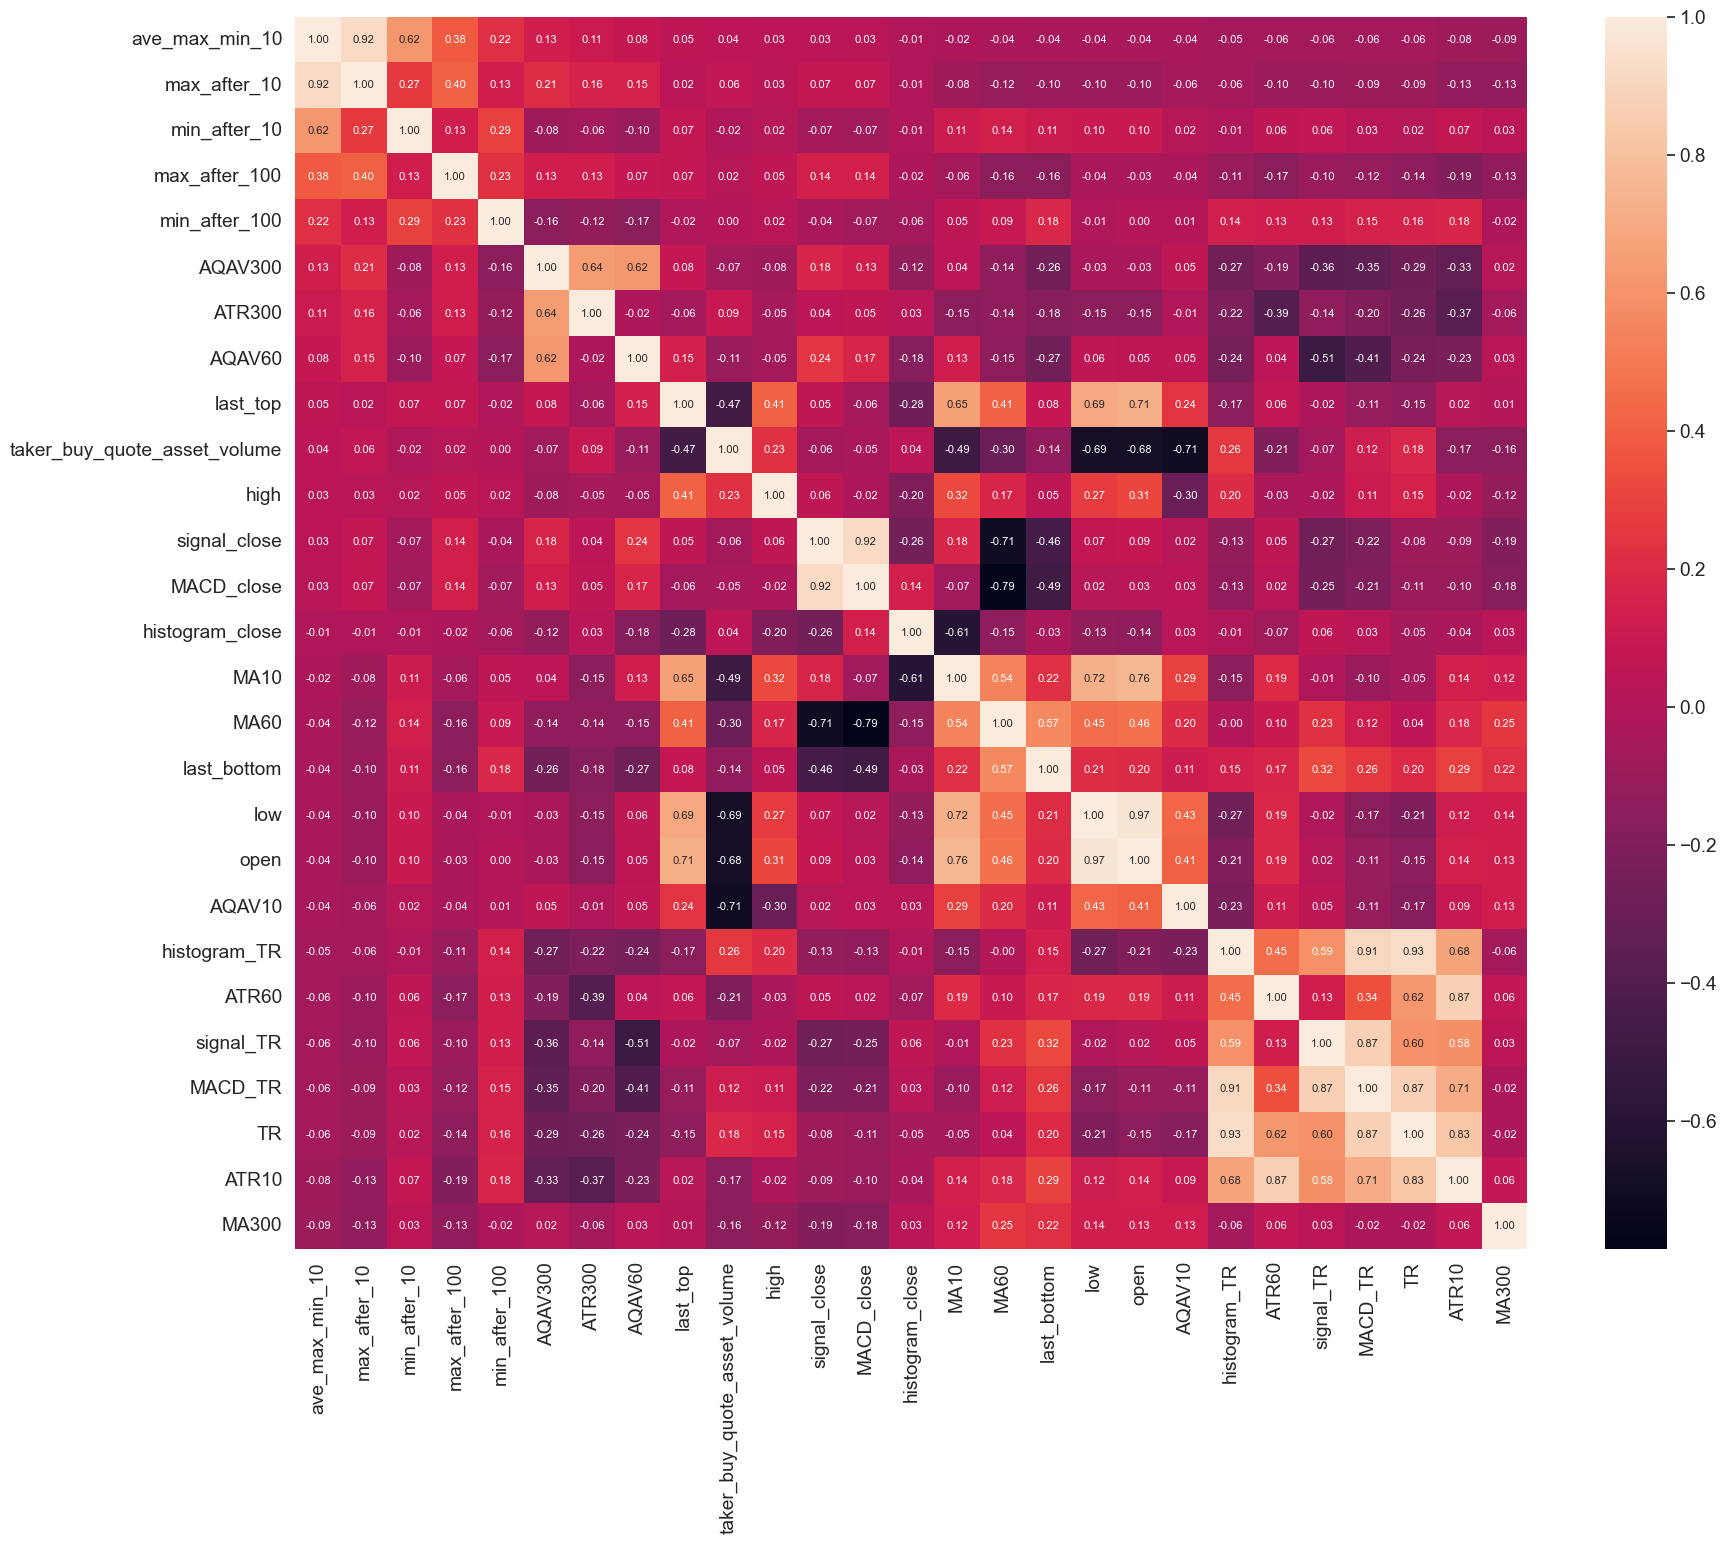

In [46]:
heatmap_data = buy_break_data.iloc[:, :].copy()

# heatmap_data = heatmap_data[heatmap_data['is_up'] == 1]
target_step = 10
target.reset_target(target_step)

target_name = target.target_name()
target.drop_others(heatmap_data)
drop_col(heatmap_data, [target.target_name()])

price_feats  = set(data_top_bottom.cols_of_features([FeatTypes.PRICE]))
dprice_feats = set(data_top_bottom.cols_of_features([FeatTypes.DPRICE]))
tr_feats     = set(data_top_bottom.cols_of_features([FeatTypes.TR]))
vol_feats    = set(data_top_bottom.cols_of_features([FeatTypes.VOLUME]))
tn_feats     = set(data_top_bottom.cols_of_features([FeatTypes.TRADE_NUM]))

for feat in price_feats:
    heatmap_data[feat] = (heatmap_data[feat] - 1) / heatmap_data['ATR10']

for feat in dprice_feats:
    heatmap_data[feat] = heatmap_data[feat] / heatmap_data['ATR10']

# for feat in (tr_feats - {'ATR10'}):
#     heatmap_data[feat] = heatmap_data[feat] / heatmap_data['ATR10']
heatmap_data['ATR300'] /= heatmap_data['ATR60']

for feat in (vol_feats - {'AQAV10'}):
    heatmap_data[feat] = heatmap_data[feat] / heatmap_data['AQAV10']
    
for feat in (tn_feats - {'AT10'}):
    heatmap_data[feat] = heatmap_data[feat] / heatmap_data['AT10']


heatmap_data.replace([np.inf, -np.inf], np.nan, inplace=True)
heatmap_data.dropna(axis=0, how='any', inplace=True)

# drop_col(heatmap_data, price_feats - {max_100, min_100})
# drop_col(heatmap_data, dprice_feats)
# drop_col(heatmap_data, tr_feats)
drop_col(heatmap_data, tn_feats)
# drop_col(heatmap_data, vol_feats)
drop_col(heatmap_data, set(data_top_bottom.cols_of_features([FeatTypes.OTHERS])))

# heatmap_font(heatmap_data, target=max_100)
target_name = 'ave_max_min_10'
heatmap_data['ave_max_min_10'] = (heatmap_data[max_win] + heatmap_data[min_win]) / 2
heatmap_font(heatmap_data, target=target_name)


# histplot(heatmap_data[max_win])
# histplot(buy_break_data[imax_win], buy_break_data[imin_win])

# sns.set()
# cols = [imax_win, imin_win, 'step_after_top','step_after_bottom']
# sns.pairplot(buy_break_data[cols], height = 2.5)
# plt.show()


In [20]:
buy_break_data.head()

,open,high,low,taker_buy_quote_asset_volume,TR,last_top,step_after_top,last_bottom,step_after_bottom,is_up,cycle_step,earn_after_1,earn_after_3,earn_after_5,earn_after_10,earn_after_30,earn_after_100,earn_after_300,MA10,MA300,ATR10,ATR300,AQAV10,AQAV300,AT10,AT300,MACD_close,signal_close,histogram_close,MACD_TR,signal_TR,histogram_TR,max_after_10,min_after_10,imax_after_10,imin_after_10,max_after_100,min_after_100,imax_after_100,imin_after_100
580,0.990392,1.002212,0.990392,0.578346,0.011820,0.996350,299.0,0.943004,153.0,1.0,146.0,0.001187,0.000494,-0.004024,-0.005859,-0.008183,-0.015132,-0.015810,0.989775,0.971050,0.002994,0.002626,0.222833,0.180981,0.245576,0.204773,0.001898,0.001510,0.000388,0.000705,0.000098,0.000607,1.004824,0.993095,0.0,9.0,1.004824,0.982696,0.0,53.0
854,0.996379,1.003366,0.996103,0.498349,0.007263,1.000119,55.0,0.964305,34.0,1.0,21.0,-0.001999,-0.005242,-0.008565,-0.010061,-0.016975,-0.032486,-0.079505,0.991954,0.977361,0.004858,0.004447,0.410232,0.372273,0.462996,0.433010,0.004853,0.003976,0.000877,-0.000030,-0.000345,0.000315,1.004928,0.985913,0.0,7.0,1.004928,0.957831,0.0,85.0
1408,0.997743,1.000683,0.996421,0.807235,0.004263,0.999596,51.0,0.984088,42.0,1.0,9.0,0.001346,0.002868,0.001716,0.001774,0.022850,0.013151,-0.045614,0.996841,0.998804,0.002514,0.004307,0.730486,2.196493,0.785408,1.995997,0.001591,0.001556,0.000035,-0.000056,-0.000155,0.000099,1.006424,0.995561,1.0,8.0,1.040868,0.995561,43.0,8.0
1801,0.999883,1.004490,0.997113,0.486998,0.007377,1.001654,73.0,0.968166,38.0,1.0,35.0,-0.005778,-0.011922,-0.016806,-0.031217,-0.043858,0.015243,0.036882,0.988203,1.024368,0.005560,0.004820,0.761339,0.592270,0.733468,0.522332,0.003864,0.001824,0.002040,0.000437,0.000008,0.000429,1.001161,0.966962,0.0,7.0,1.030319,0.887693,80.0,45.0
1873,0.989860,1.005379,0.989025,0.710418,0.016354,0.999401,72.0,0.963261,110.0,0.0,38.0,-0.002103,-0.004315,0.017218,0.016445,0.009551,0.009835,0.025829,0.981815,0.995455,0.010488,0.006144,0.394977,0.386417,0.470398,0.368679,0.009693,0.008352,0.001340,-0.000209,-0.000211,0.000002,1.025099,0.980570,8.0,2.0,1.025099,0.980022,8.0,62.0


In [21]:
heatmap_data.head()

,open,high,low,taker_buy_quote_asset_volume,TR,last_top,last_bottom,MA10,MA300,ATR10,ATR300,AQAV10,AQAV300,MACD_close,signal_close,histogram_close,MACD_TR,signal_TR,histogram_TR,max_after_10,min_after_10,max_after_100,min_after_100,imax_after_100,ave_max_min_100
580,-3.209142,0.738885,-3.209142,2.595419,3.948028,-1.218952,-19.036736,-3.415153,-9.669248,0.002994,0.877086,0.222833,0.812183,0.633901,0.504388,0.129513,0.235598,0.032743,0.202856,1.611355,-2.306408,1.611355,-5.779587,0.0,-2.084116
854,-0.745342,0.692935,-0.802277,1.214799,1.495212,0.024586,-7.347955,-1.656250,-4.660276,0.004858,0.915526,0.410232,0.907471,0.999027,0.818412,0.180616,-0.006161,-0.070980,0.064819,1.014493,-2.899845,1.014493,-8.680771,0.0,-3.833139
1408,-0.898105,0.271903,-1.424059,1.105065,1.695963,-0.160670,-6.330678,-1.256798,-0.475648,0.002514,1.713714,0.730486,3.006893,0.632773,0.618914,0.013859,-0.022133,-0.061581,0.039447,2.555617,-1.765998,16.259269,-1.765998,43.0,7.246636
1801,-0.021010,0.807564,-0.519336,0.639660,1.326899,0.297420,-5.725822,-2.121922,4.383011,0.005560,0.867017,0.761339,0.777933,0.694996,0.328042,0.366954,0.078667,0.001435,0.077231,0.208785,-5.942486,5.453352,-20.200249,80.0,-7.373449
1873,-0.966759,0.512812,-1.046399,1.798629,1.559211,-0.057133,-3.502770,-1.733795,-0.433296,0.010488,0.585784,0.394977,0.978326,0.924120,0.796330,0.127790,-0.019903,-0.020124,0.000221,2.393006,-1.852493,2.393006,-1.904778,8.0,0.244114


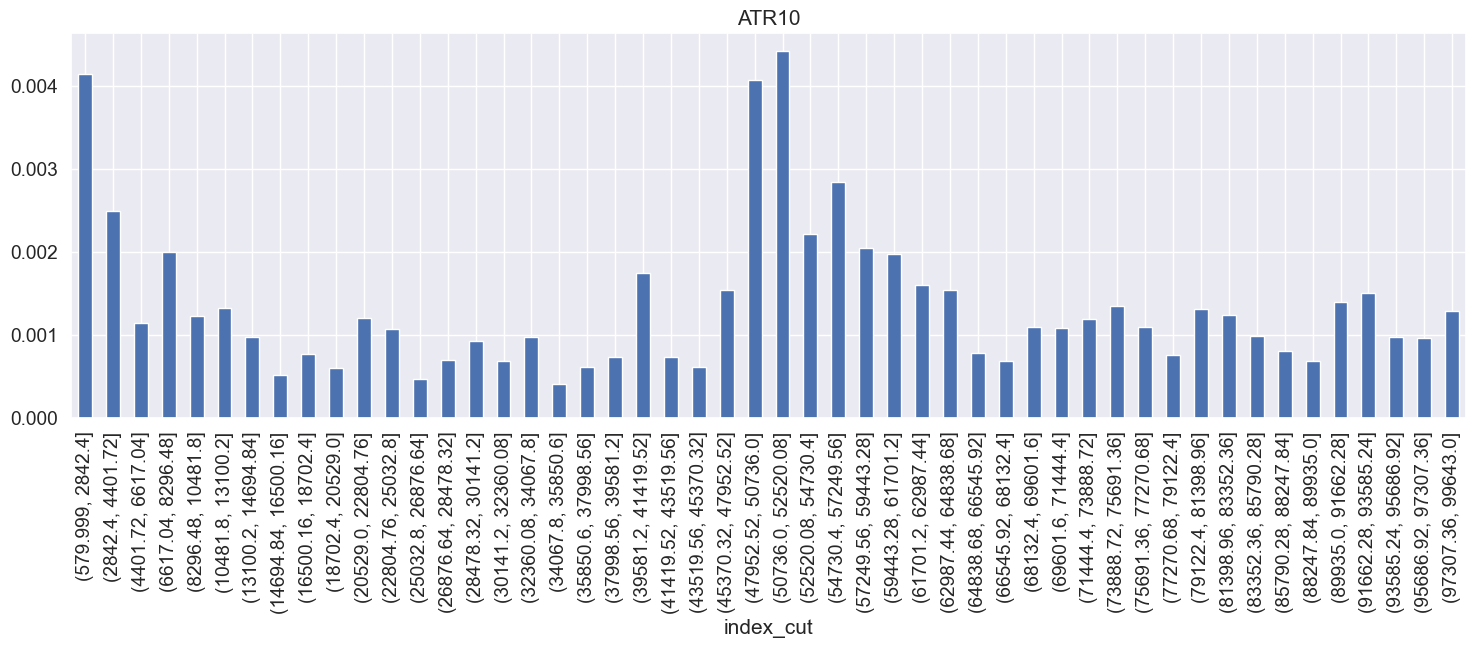

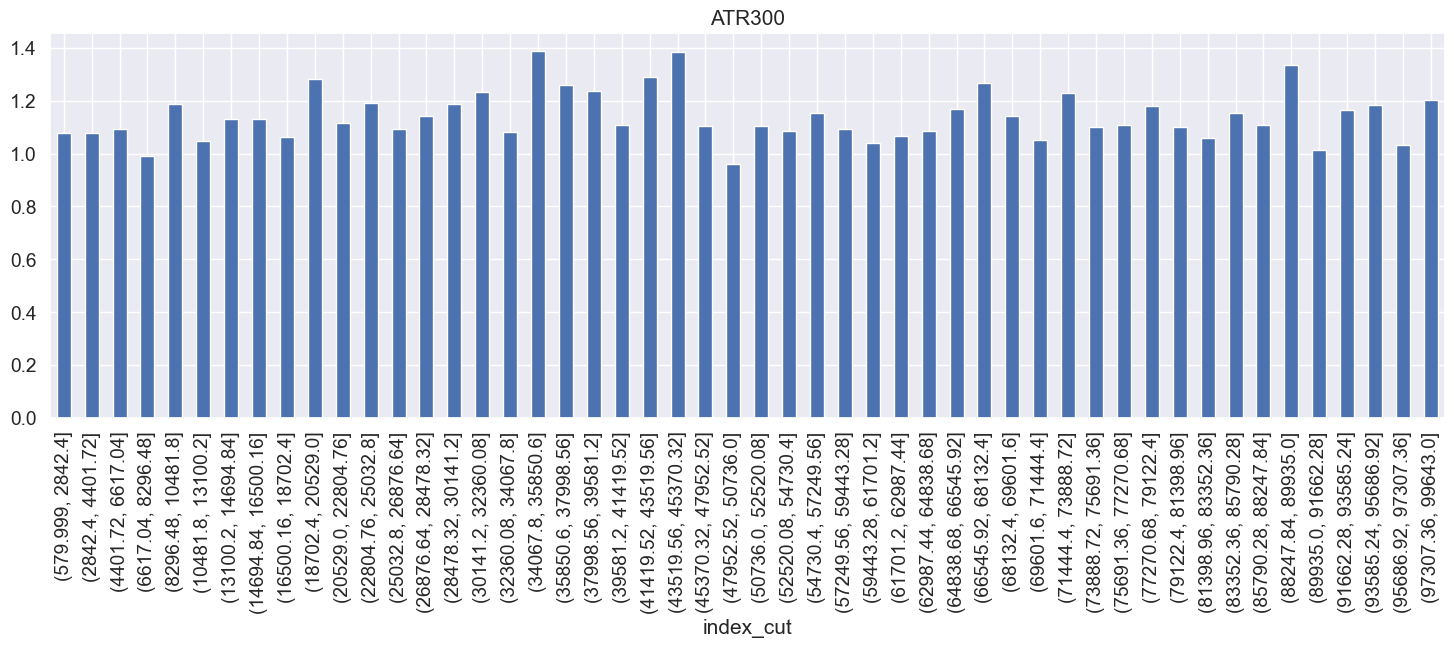

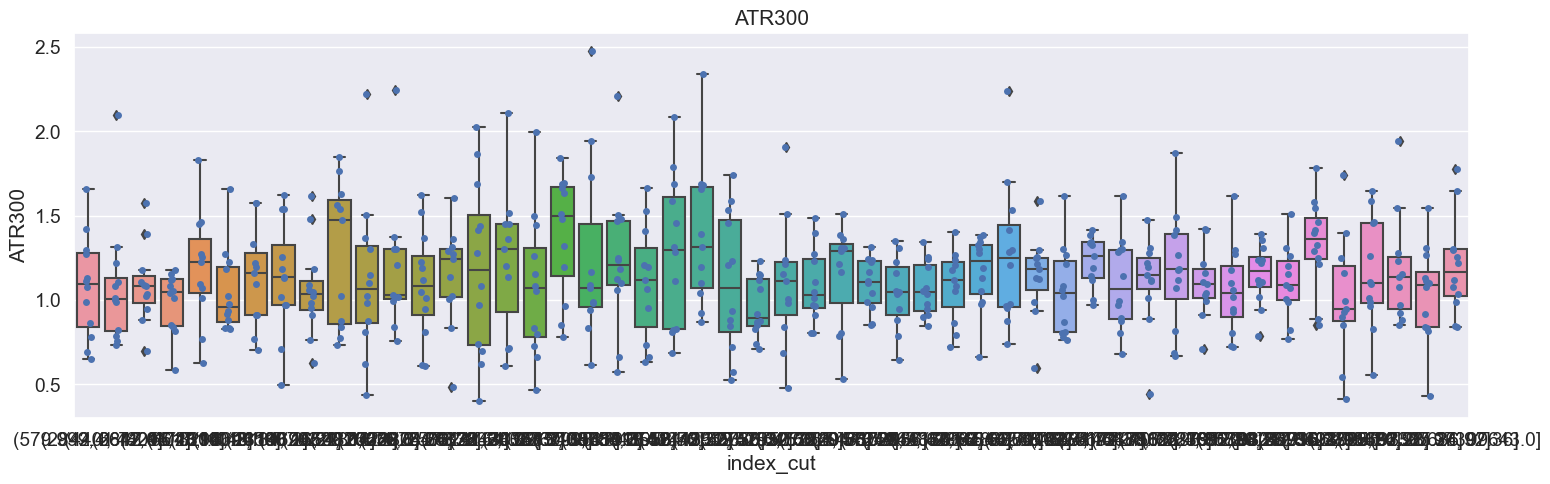

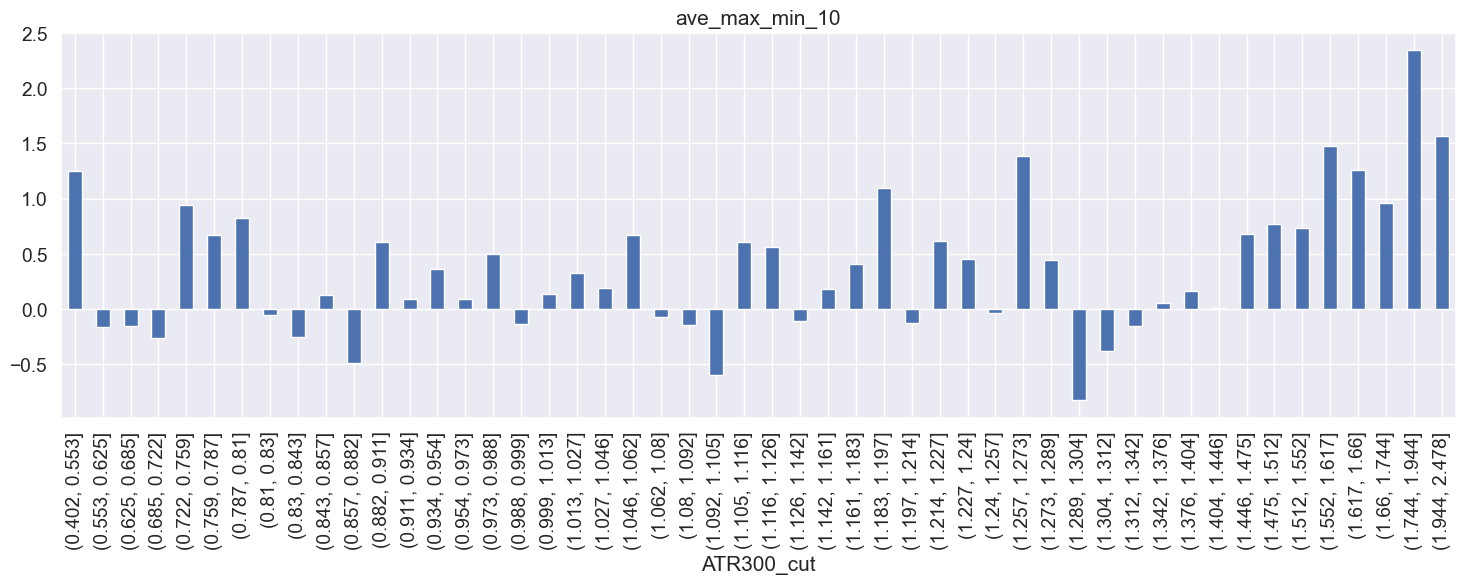

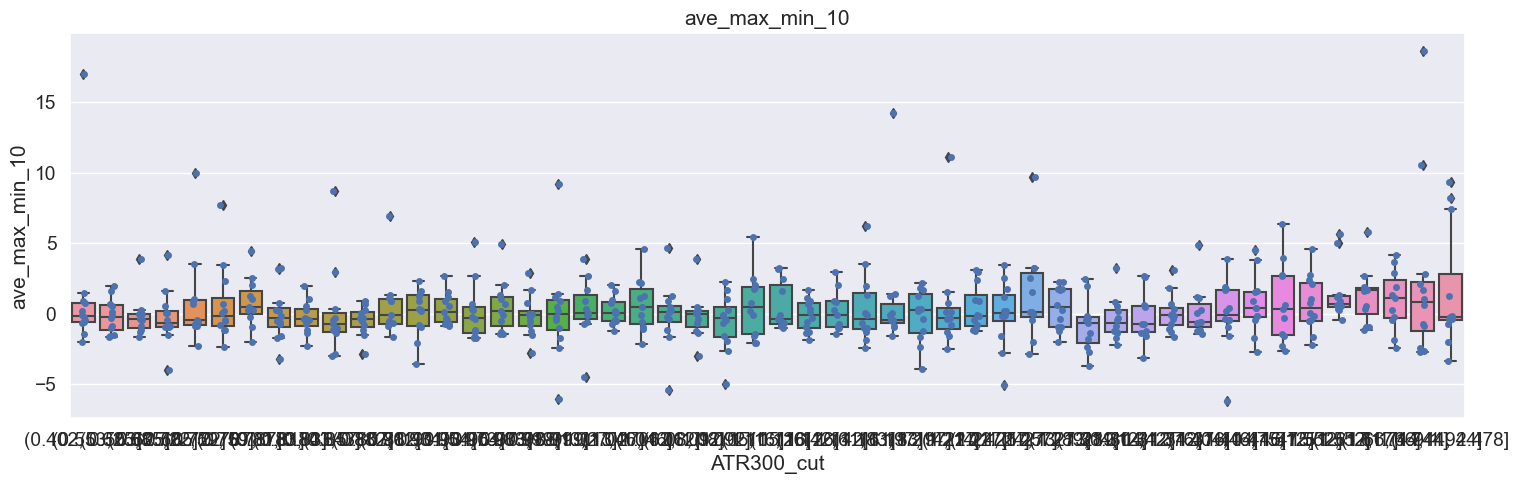

In [48]:
used_feats = ['ATR300', 'signal_close', 'AQAV300', 'MA300', 'signal_TR', 'last_bottom', 'ATR10']

plot_data = heatmap_data.copy()
plot_data['index'] = plot_data.index
checked = 'ATR300'
plt_A_B(plot_data, 'index', 'ATR10', cut_num=50)
plt_A_B(plot_data, 'index', checked, cut_num=50)
plt_box_A_B(plot_data, 'index', checked, cut_num=50)
plt_A_B(plot_data, checked, target_name, cut_num=50)
plt_box_A_B(plot_data, checked, target_name, cut_num=50)

atr300: 1.5396457765667286
MA300: -5.434485241180777


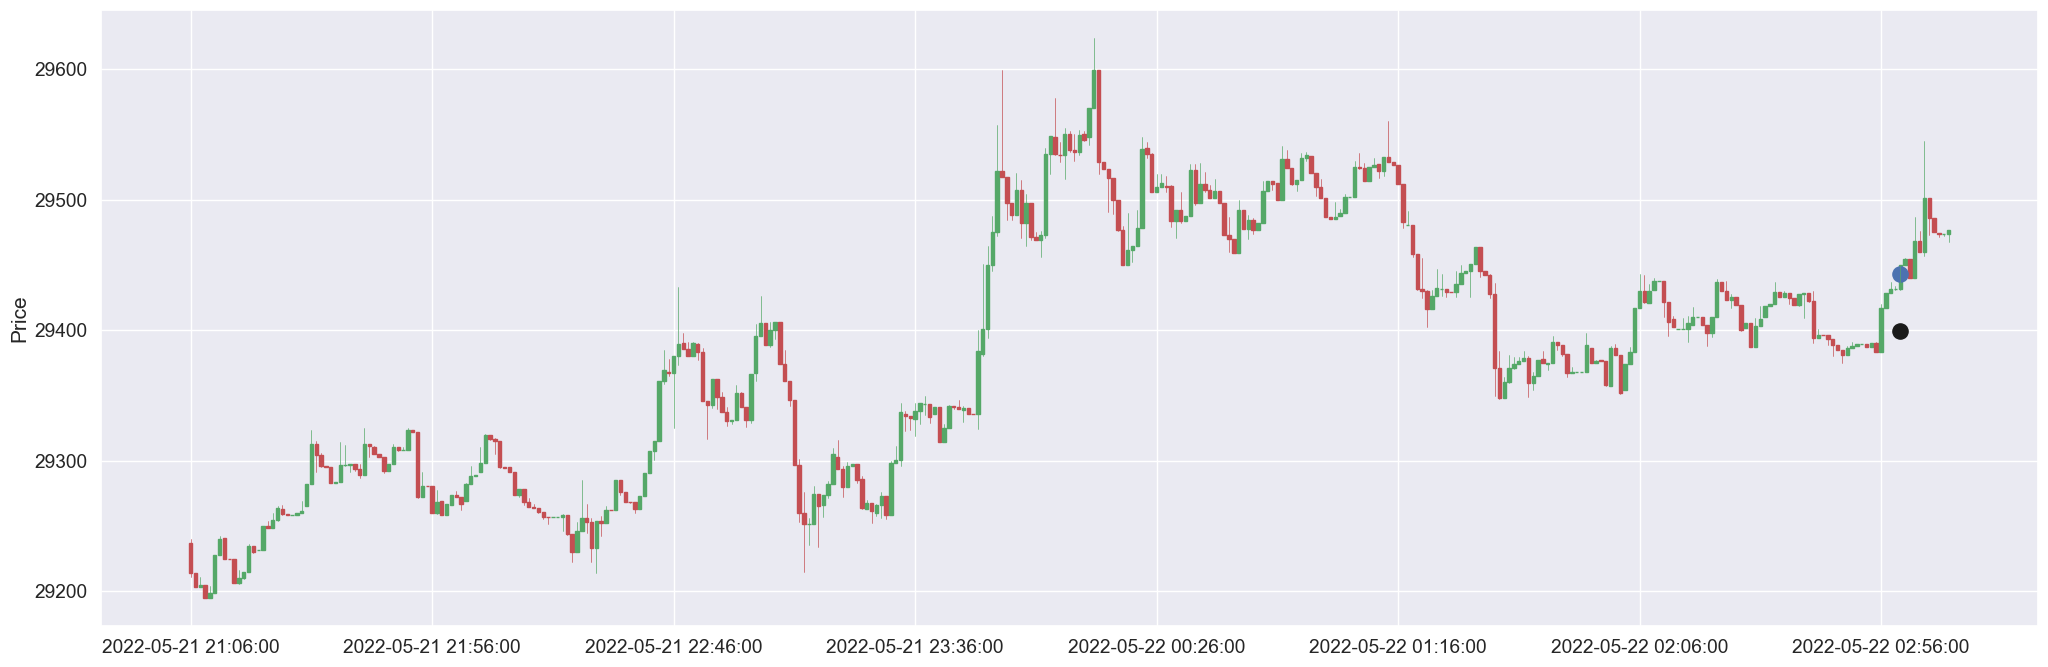

In [60]:
start: int = heatmap_data[heatmap_data['ATR300'] > 1.5].index[8] # type: ignore
last_top_idx = start - full_data.loc[start, 'step_after_top']
close: float = full_data.loc[start, 'close']
atr10: float = heatmap_data.loc[start, 'ATR10']
ma300: float = heatmap_data.loc[start, 'MA300']
print(f"atr300: {heatmap_data.loc[start, 'ATR300']}")
print(f"MA300: {ma300}")
points = [PricePlot.Points(start, full_data.loc[start, 'last_top'], s=120, c='b'),
          PricePlot.Points(start, close * (1 + ma300 * atr10), s=120, c='k')]
plot(full_data, last_top_idx-300, start+10, points)
# heatmap_data.loc[start, :]
# buy_break_data.loc[start, :]

### 线性回归预测 max, min

10.975511331409614
max_after_100:
rmse: 10.882103992263943
max_after_100 = 7.363599719294353 + -0.2418944963215112 * MA300



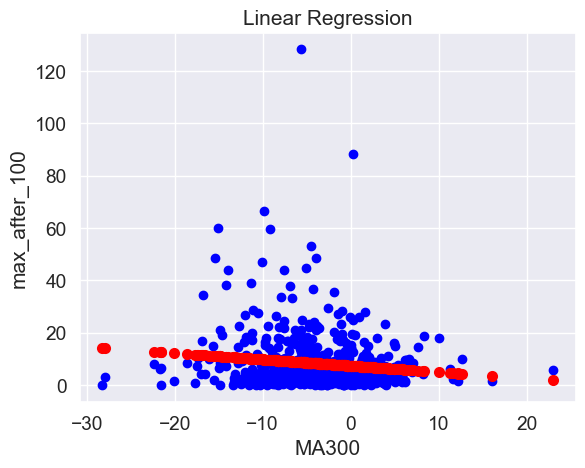

min_after_100:
rmse: 7.46613120981793
min_after_100 = -7.052052027872862 + -0.02500803100761294 * MA300



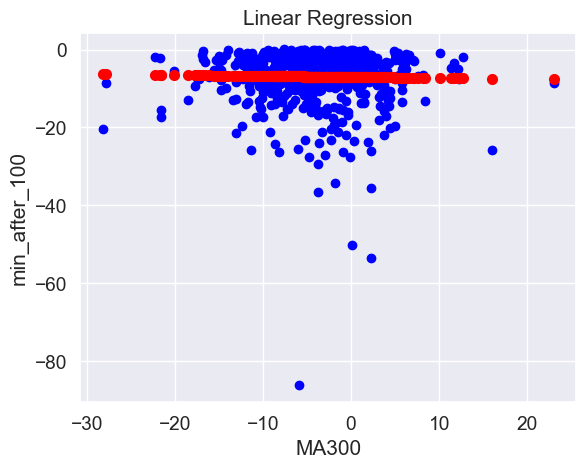

In [24]:
# 生成 X 和 Y 的随机数据
# x_name = used_feats + [imax_100]
x_name = ['MA300']
y_max_name = max_100
y_min_name = min_100
# y_height_name = 'max_min_100'

# ATR10 因为拖尾严重，所以选择 3 sigma 以内的数据。
train_data = heatmap_data.copy()

# 获取 X, Y
X = train_data[x_name].values.astype(np.float64)

# base = train_data['last_top']     # 误差更大，所以放弃
base = 1    # 1 表示 close

Y_max = (train_data[y_max_name] / base).values.astype(np.float64)
Y_min = (train_data[y_min_name] / base).values.astype(np.float64)
# Y_height = (train_data[y_height_name] / base).values.astype(np.float64)
print(np.std(Y_max))

def linear_regression(X, Y, x_name, y_name, plot=False, plot_name=None):
    print(f'{y_name}:')
    # 训练线性回归模型
    model = LinearRegression()
    model.fit(X, Y)
    Y_train_pred = model.predict(X)

    # 计算均方误差
    rmse = sqrt(mean_squared_error(Y, Y_train_pred))
    print(f'rmse: {rmse}')
    s = ''.join([f" + {model.coef_[i]} * {x_name[i]}" for i in range(len(x_name))])
    print(f'{y_name} = {model.intercept_}{s}\n')

    if plot:
        feat_id = 0
        if plot_name is not None:
            feat_id = [i for i in range(len(x_name)) if x_name[i] == plot_name][0]
            
        # 绘制散点图和拟合直线
        plt.scatter(X[:, feat_id], Y, color='blue')
        plt.scatter(X[:, feat_id], Y_train_pred, color='red', linewidth=2)
        plt.title('Linear Regression')
        plt.xlabel(x_name[feat_id])
        plt.ylabel(y_name)
        plt.show()
    return model

model_max = linear_regression(X, Y_max, x_name, y_max_name, plot=True)
model_min = linear_regression(X, Y_min, x_name, y_min_name, plot=True)

可以看到方差随着 ATR 增大而减小，所以再求一个方差与 ATR 的线性回归

In [25]:
def plot_with_dis(model, std_model, X, Y, x_name, y_name, Y_dis=None, xlim=None):
    # 绘制散点图和拟合直线
    plt.scatter(X, Y, color='blue')
    plt.plot(X, model.predict(X), color='red', linewidth=2)
    plt.plot(X, model.predict(X) + 2 * std_model.predict(X), color='red', linewidth=2)
    plt.plot(X, model.predict(X) - 2 * std_model.predict(X), color='red', linewidth=2)
    plt.title('Linear Regression')
    plt.xlabel(x_name)
    plt.ylabel(y_name)
    plt.show()

    if Y_dis is not None:
        # 对偏差进行标准化处理，及横坐标表示该值偏离了几个 sigma。
        histplot(Y_dis / std_model.predict(X), xlim=xlim)

Y_max_dis:
rmse: 8.46470785068481
Y_max_dis = 5.603643929790196 + -0.2664041343644032 * MA300



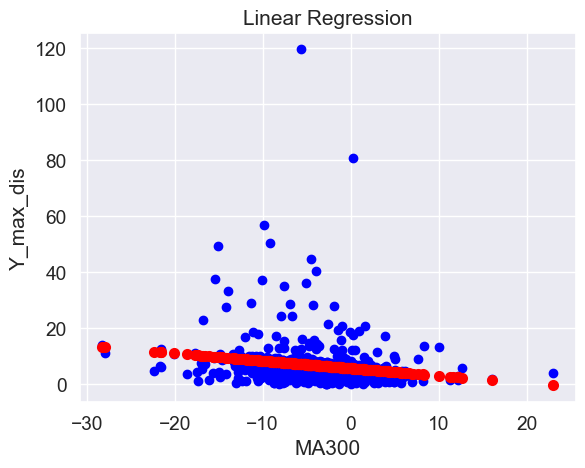

Y_min_dis:
rmse: 5.575158089794416
Y_min_dis = 5.105768542422377 + 0.03661160516595425 * MA300



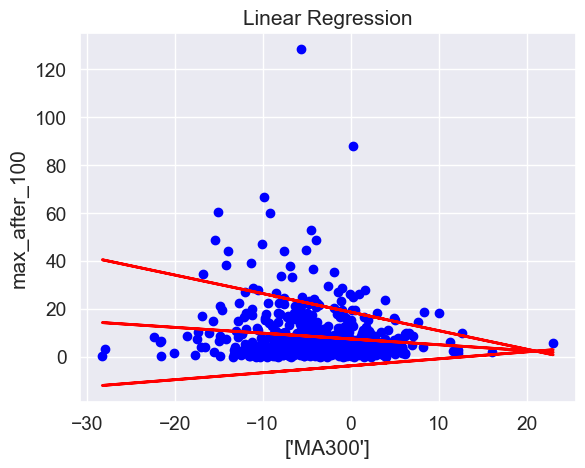

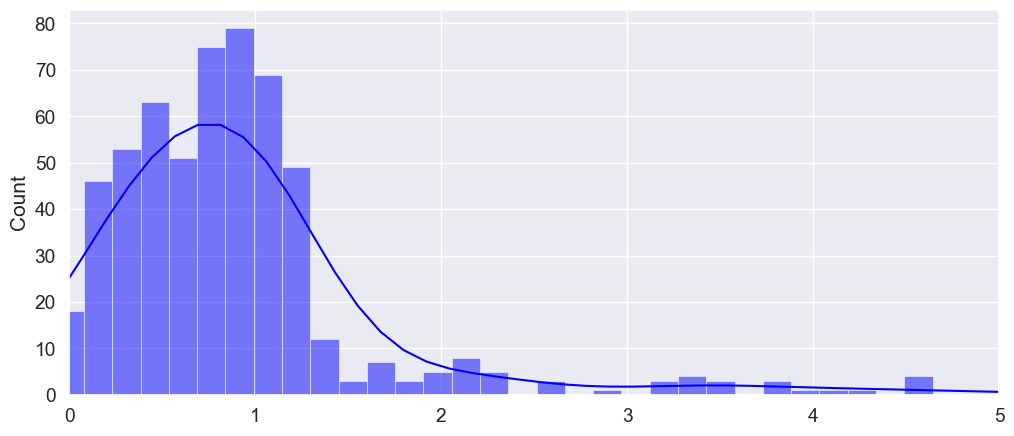

In [26]:
Y_max_dis = np.abs(Y_max - model_max.predict(X))
Y_min_dis = np.abs(Y_min - model_min.predict(X))
std_model_max = linear_regression(X, Y_max_dis, x_name, 'Y_max_dis', plot=True)
std_model_min = linear_regression(X, Y_min_dis, x_name, 'Y_min_dis')

plot_with_dis(model_max, std_model_max, X, Y_max, x_name, y_max_name, Y_max_dis, xlim=[-0, 5])
# plot_with_dis(model_min, std_model_min, X, Y_min, x_name, y_min_name, Y_min_dis)

可以看到有很多点超过了 2 倍 dis，可以认为这些情况完全属于另一种情况。

即大部分突破并没有效果，短期走势依然处于随机游走状态，超过 2 sigma 则属于真正的突破，明显不是随机游走。

因此我们需要除去这部分点，然后重新对符合随机游走的点做线性回归

max:
0.9136442141623489
max_after_100:
rmse: 5.089398103109064
max_after_100 = 5.369969515937285 + -0.1405463449569973 * MA300

dis:
rmse: 3.0509268632629976
dis = 3.4030269848487937 + -0.14530411185155542 * MA300

min:
0.9222797927461139
min_after_100:
rmse: 4.114727481129847
min_after_100 = -5.372054748766017 + 0.004170397580109342 * MA300

dis:
rmse: 2.3806905211500626
dis = 3.3395256901438084 + -0.004177622297268087 * MA300



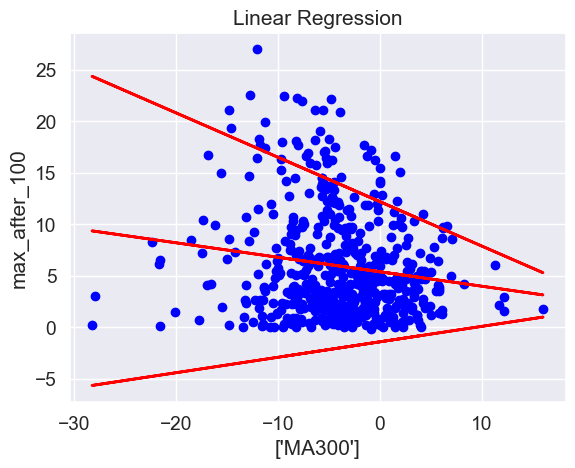

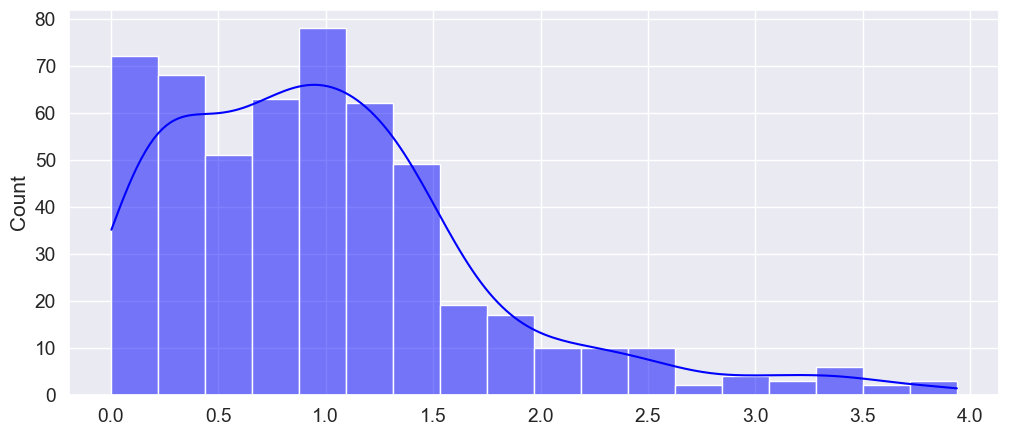

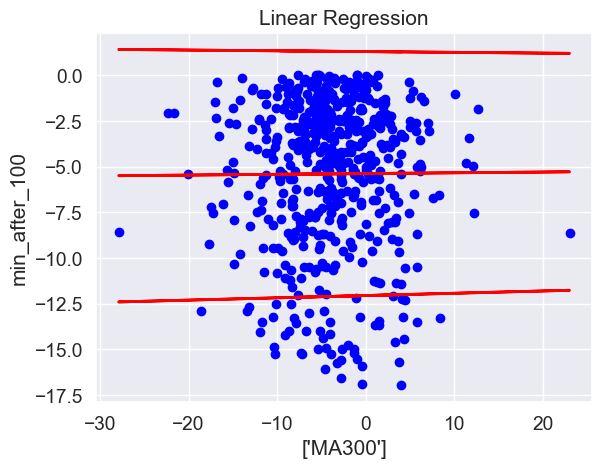

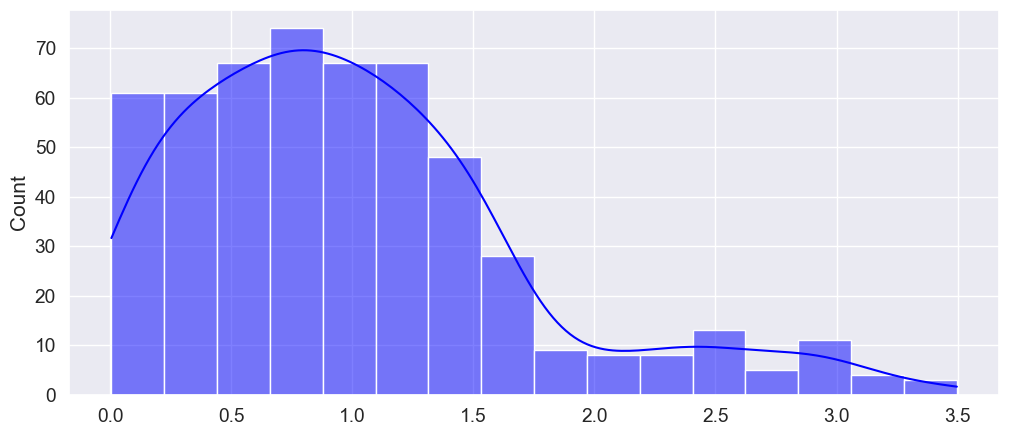

In [27]:
def train_again(model, std_model, X, Y, x_name, y_name):
    if 'max' in y_name:
        print('max:')
        valid = Y < model.predict(X) + 2 * std_model.predict(X)
    else:
        print('min:')
        valid = Y > model.predict(X) - 2 * std_model.predict(X)

    print(sum(valid) / len(valid))
    # 2 倍 dis 以内的数据已经包括了 92 % 的数据，对该数据重新做回归，保证模型不受 outlier 的影响
    X = X[valid]
    Y = Y[valid]
    model = linear_regression(X, Y, x_name, y_name)
    Y_dis = np.abs(Y - model.predict(X))
    std_model = linear_regression(X, Y_dis, x_name, 'dis')
    return model, std_model, valid

model_max, std_model_max, valid_max = train_again(model_max, std_model_max, X, Y_max, x_name, y_max_name)
model_min, std_model_min, valid_min = train_again(model_min, std_model_min, X, Y_min, x_name, y_min_name)

X_max = X[valid_max]
X_min = X[valid_min]
Y_max = Y_max[valid_max]
Y_min = Y_min[valid_min]

# New dis
Y_max_dis = np.abs(Y_max - model_max.predict(X_max))
Y_min_dis = np.abs(Y_min - model_min.predict(X_min))
plot_with_dis(model_max, std_model_max, X_max, Y_max, x_name, y_max_name, Y_max_dis)
plot_with_dis(model_min, std_model_min, X_min, Y_min, x_name, y_min_name, Y_min_dis)

所以可以使用修正的模型，预测最高点和最低点，同时预测 std，当超多 3 std 时开始做空，超过 5 std 时开多。
开多后如何卖出或止损待考虑

### 根据 max, min, imax, imain 绘制 K 线便于直观观察

In [28]:
def value_predict(model, std_model, feat):
    x = np.array(feat, ndmin=2)
    x = x.reshape(-1, 1)
    value = model.predict(x)
    dis = [max(v, 0) for v in std_model.predict(x)]

    if len(value) == 1:
        value = value[0]

    if len(dis) == 1:
        dis = dis[0]
    
    return value, dis

def price_pred(close, pred, dis, atr10, log=False):
    price = close * (1 + atr10 * (pred + dis))
    if log:
        print(f"{price :.2f}")
    return price

n = 10
test_atr = heatmap_data['ATR300'].iloc[n]
atr10 = heatmap_data['ATR10'].iloc[n]

print(f"test tr: {test_atr}, atr10: {atr10}")
value_max, dis_max = value_predict(model_max, std_model_max, test_atr)
value_min, dis_min = value_predict(model_min, std_model_min, test_atr)
print(value_max, dis_max)
print(value_min, dis_min)
price_pred(1, value_min, 0, atr10)

test tr: 1.302844529401049, atr10: 0.0025487814639137407
5.186859479282749 3.2137183176235165
-5.366621369093344 3.334082897787909


0.9863216549306115

max_10 num: 37
Last top: 0.7824, Open: 0.7387, 
          max_pred: 		5.2309, 	min_pred: 		-5.3679
          max_pred + 1std: 	8.4901, 	min_pred - 1std: 	-8.7033
          actual_max: 		0.4929, 	actual_min: 		-1.8078


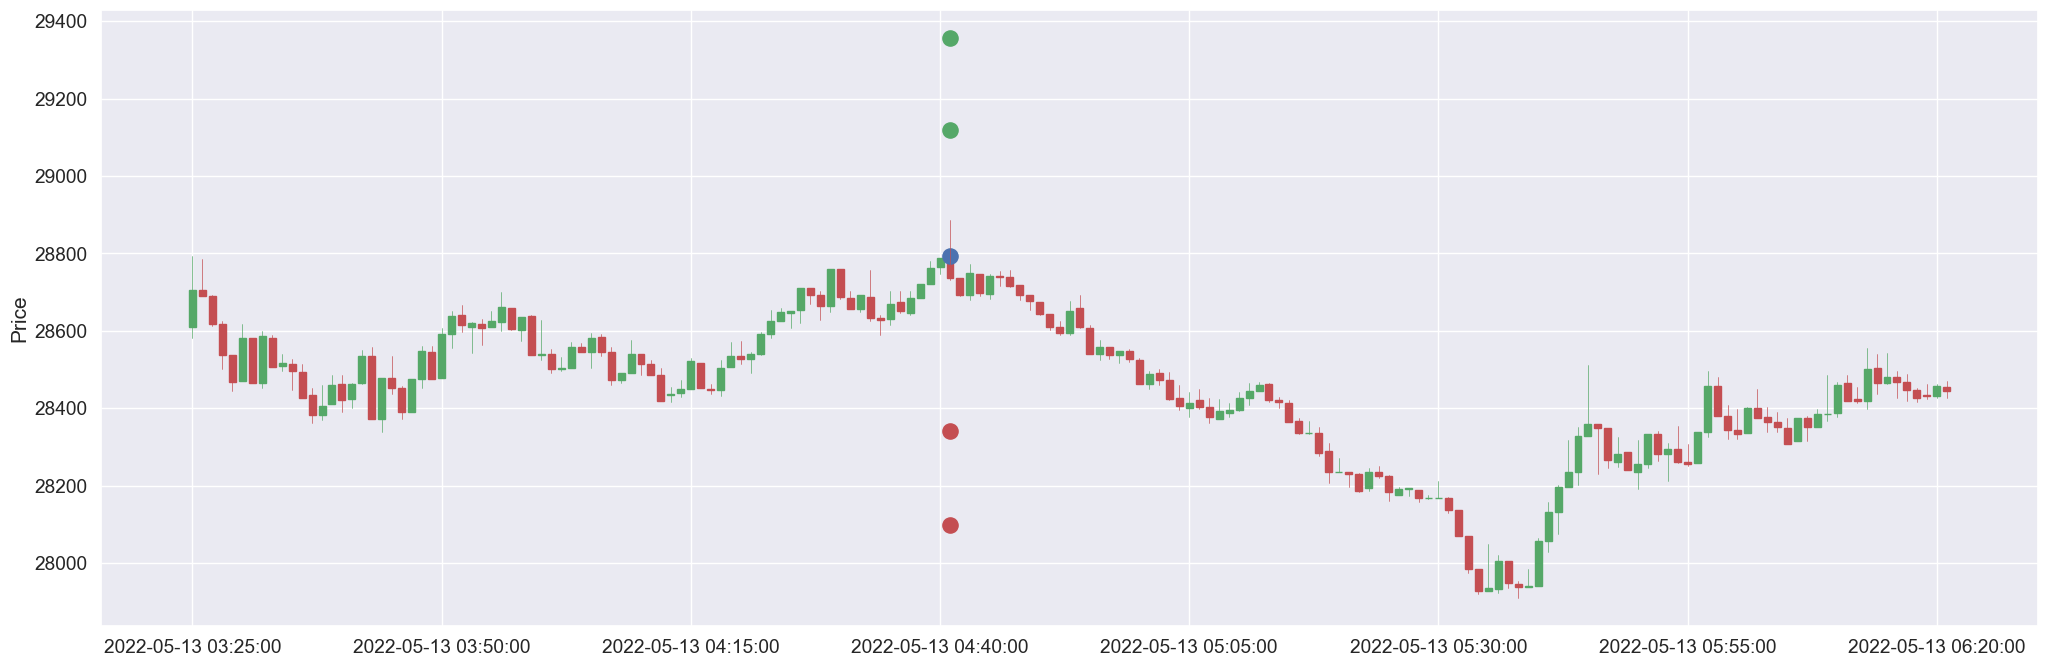

In [30]:
pred_data = heatmap_data.copy()

assert len(x_name) == 1
feat_name = pred_data[x_name[0]].values
atr10 = pred_data['ATR10'].values
max_pred, dis_max = value_predict(model_max, std_model_max, feat_name)
min_pred, dis_min = value_predict(model_min, std_model_min, feat_name)
temp_df = pd.DataFrame({'max_pred': max_pred, 'dis_max': dis_max, 'min_pred': min_pred, 'dis_min': dis_min})
temp_df.index = pred_data.index
pred_data = pd.concat([pred_data, temp_df], axis=1)

pred_data['actual_dis_max'] = pred_data[max_win] - pred_data['max_pred']
pred_data['actual_dis_min'] = pred_data[min_win] - pred_data['min_pred']
pred_data['actual_dis_max/dis'] = pred_data['actual_dis_max'] / pred_data['dis_max']
pred_data['actual_dis_min/dis'] = pred_data['actual_dis_min'] / pred_data['dis_min']


max_10 = pred_data[pred_data['actual_dis_min/dis'] < 0].index.to_list()
# imax = buy_break_data[buy_break_data[imax_win] == 0].index.to_list()
# imin = buy_break_data[buy_break_data[imin_win] == 0].index.to_list()

# idx_max_first = (buy_break_data[imax_win] < buy_break_data[imin_win]) # & (buy_break_data[max_win] > 1.02)
# idx_min_first = buy_break_data[imax_win] > buy_break_data[imin_win]
# idx_max_min = buy_break_data[imax_win] == buy_break_data[imin_win]

# imax_first = buy_break_data[idx_max_first].index.to_list()
# imin_first = buy_break_data[idx_min_first].index.to_list()
# imax_min = buy_break_data[idx_max_min].index.to_list()

print(f'max_10 num: {len(max_10)}')
start = buy_break_data.index.values[10]
# start = max_10[10]
last_top_idx = start - full_data.loc[start, 'step_after_top']

# Predict max value and dis
atr10, max_pred, dis_max, min_pred, dis_min = \
  pred_data.loc[start, ['ATR10', 'max_pred', 'dis_max', 'min_pred', 'dis_min']]
close: float = full_data.loc[start, 'close'] # type: ignore

points = [PricePlot.Points(start, full_data.loc[start, 'last_top'], s=120, c='b', label='last_top'),
          PricePlot.Points(start, price_pred(close, max_pred, 0, atr10), s=120, c='g', label=''),
          PricePlot.Points(start, price_pred(close, max_pred, 1*dis_max, atr10), s=120, c='g', label=''),
          PricePlot.Points(start, price_pred(close, min_pred, 0, atr10), s=120, c='r', label=''),
          PricePlot.Points(start, price_pred(close, min_pred, -1*dis_min, atr10), s=120, c='r', label='')]

def d(name):
    return pred_data.loc[start, name]
print(f"""Last top: {d('last_top') :.4f}, Open: {d('open') :.4f}, 
          max_pred: \t\t{max_pred :.4f}, \tmin_pred: \t\t{min_pred :.4f}
          max_pred + 1std: \t{max_pred + 1*dis_max :.4f}, \tmin_pred - 1std: \t{min_pred - 1*dis_min :.4f}
          actual_max: \t\t{d(max_win) :.4f}, \tactual_min: \t\t{d(min_win) :.4f}""")
        #   actual_max idx: \t{d(imax_win) :.4f}, \tactual_min idx: \t{d(imin_win) :.4f}""")
plot(full_data, last_top_idx, start+100, points)

### 制定策略，统计信息

1. 先高后低，和先低后高的数量

超过 n * dis 开始做多，移动止损

In [33]:
debug = False
debug_num = 10
plot_idx = -1

def prt(str):
    if debug:
        print(str)

d = lambda idx, name: full_data.loc[idx, name]

trade_data = pred_data.copy()
trade_data['earn'] = 0
trade_data['reason'] = 'NoTrade'
trade_data['buy_idx'] = 0
check_num = 0
for idx in trade_data.index:
    close: float = full_data.loc[idx, 'close'] # type: ignore
    last_top: float = full_data.loc[idx, 'last_top'] # type: ignore
    # Predict max value and dis
    atr10, max_pred, dis_max, min_pred, dis_min = \
        trade_data.loc[idx, ['ATR10', 'max_pred', 'dis_max', 'min_pred', 'dis_min']]
    atr10 = trade_data.loc[idx, 'ATR10']

    buy_dir_above = True
    buy_price  = max(close, last_top)
    exit_prcie = price_pred(buy_price, max_pred, -0 * dis_max, atr10)
    stop_price = price_pred(buy_price, min_pred, +0 * dis_min, atr10)

    rw = (exit_prcie - buy_price) / buy_price
    rl = (buy_price - stop_price) / buy_price
    p = 0.565
    # times = p / rl - (1 - p) / rw
    # times = 0.1 * buy_price / (exit_prcie - buy_price) # Expect earn 10%
    times = 1

    # if times <= 0:
    #     print(f"idx: {idx}, times: {times}, rw: {rw:.5f}, rl: {rl:.5f}")
    prt(f"buy_price: {buy_price:.2f}, exit_prcie: {exit_prcie:.2f}, stop_price: {stop_price:.2f}, rw: {rw:.5f}, rl: {rl:.5f}")
    

    buy_idx    = None
    sell_price = None
    sell_idx   = None
    end_time   = 100

    def sell(price, j_idx, reason):
        global sell_price, buy_price, sell_idx, trade_data, buy_idx, atr10, dis_max, times
        assert price >= d(j_idx, 'low') and price <= d(j_idx, 'high'), \
            f"idx: {idx}, price: {price}, low: {d(j_idx, 'low')}, high: {d(j_idx, 'high')}"
        sell_price = price
        sell_idx   = j_idx 

        earn = times * (price - buy_price) / buy_price
        trade_data.loc[idx, 'earn'] = earn
        trade_data.loc[idx, 'reason'] = reason
        # prt(f"Sold, idx: {sell_idx}, price: {price}, earn: {earn * 100:.2f} %, earn/atr: {earn/atr10:.2f}")
        prt(f"Sold: {reason}, step: {sell_idx-buy_idx}, times: {times:.2f}, earn: {earn * 100:.2f} %, earn/atr: {earn/atr10:.2f}")

    if exit_prcie > buy_price and stop_price < buy_price and times > 0:
        for i in range(idx+1, idx+3):
            high = d(i, 'high')
            low = d(i, 'low')
            open = d(i, 'open')

            if buy_dir_above and high >= buy_price:
                buy_price = max(open, buy_price)
                buy_idx = i
            elif (not buy_dir_above) and low <= buy_price:
                buy_price = min(open, buy_price)
                buy_idx = i

            if buy_idx is not None:
                trade_data.loc[idx, 'buy_idx'] = buy_idx
                prt(f"idx: {idx}")
                # prt(f"Bought, idx: {buy_idx}, price: {buy_price:.1f}, atr10: {atr10:.5f}, dis: {dis_max:.2f}")
                prt(f"Bought, step: {buy_idx-idx}, atr10: {atr10:.5f}, dis: {dis_max:.2f}")
                break

    if buy_idx is not None:
        j_idx = buy_idx
        
        while True:
            j_idx += 1
            open = d(j_idx, 'open')
            low = d(j_idx, 'low')
            high = d(j_idx, 'high')
            # # 固定止损
            if low < stop_price:
                sell(min(open, stop_price), j_idx, 'stop')
                break
            
            # 止盈
            # last_low = min(d(range(j_idx-4, j_idx), 'low'))
            # if low < last_low:
            #     sell(min(open, last_low), j_idx, 'exit')
            #     break
            if high > exit_prcie:
                sell(max(open, exit_prcie), j_idx, 'exit')
                break

            # Protect dead loop
            if j_idx > buy_idx + end_time:
                sell(open, j_idx, 'end')
                break

        assert sell_price is not None

    # plot
    if idx == plot_idx:
        points = [
            PricePlot.Points(idx, d(idx, 'last_top'), s=200, c='b', label='last_top'),
                PricePlot.Points(idx, price_pred(buy_price, max_pred, 0, atr10), s=120, c='y', label=''),
                PricePlot.Points(idx, price_pred(buy_price, max_pred, -1*dis_max, atr10), s=120, c='y', label=''),
                PricePlot.Points(idx, price_pred(buy_price, min_pred, 0, atr10), s=120, c='y', label=''),
                PricePlot.Points(idx, price_pred(buy_price, min_pred, +1*dis_min, atr10), s=120, c='y', label='')
        ]

        if sell_price:
            points += [
                PricePlot.Points(buy_idx, buy_price, s=200, c='k', label='Buy'),
                PricePlot.Points(sell_idx, sell_price, s=200, c='k', label='Sell')]
        plot(full_data, idx-20, idx+40, points)

    # For debug
    check_num += 1
    if debug and check_num >= debug_num:
        break
    
trade_data['earn/atr']     = trade_data['earn'] / trade_data['ATR10']
# trade_data['earn/atr/dis'] = trade_data['earn'] / trade_data['ATR10'] / trade_data['dis_max']

is_trade_arr = trade_data['earn'] != 0
is_stop_arr = trade_data['reason'] == 'stop'
trade_idx = trade_data[is_trade_arr].index
trade_num = sum(is_trade_arr)
print(f"Trade num:          {trade_num}")
print(f"Trade percentage:   {trade_num / len(trade_data) * 100:.2f} %")
print(f"Stop num:           {sum(is_stop_arr)}")
print(f"Stop percentage:    {sum(is_stop_arr) / trade_num * 100:.2f} %")
print(f"Exit num:           {sum(trade_data['reason'] == 'exit')}")
print(f"Exit percentage:    {sum(trade_data['reason'] == 'exit') / trade_num * 100:.2f} %")
print(f"Trade num per day:  {trade_num / (len(full_data) / (60 * 24))}")
print(f"Total earn:         {trade_data['earn'].sum() * 100:.2f} %")
print(f"Average earn:       {trade_data['earn'].sum() / trade_num * 100:.3f} %")
print(f"Earn rate:          {sum(trade_data['earn'] > 0) / trade_num * 100:.2f} %")
print()
print(f"Total earn/atr:         {trade_data['earn/atr'].sum():.2f}")
print(f"Average earn/atr:       {trade_data['earn/atr'].sum() / trade_num:.2f}")
print(f"Std of earn/atr:        {trade_data.loc[trade_idx, 'earn/atr'].std() / trade_data.loc[trade_idx, 'earn/atr'].mean():.2f}")
print()
# print(f"Total earn/atr/dis:     {trade_data['earn/atr/dis'].sum():.2f}")
# print(f"Average earn/atr/dis:   {trade_data['earn/atr/dis'].sum() / trade_num:.2f}")
# print(f"Std of earn/atr/dis:    {trade_data.loc[trade_idx, 'earn/atr/dis'].std() / trade_data.loc[trade_idx, 'earn/atr/dis'].mean():.2f}")
# print()

Trade num:          453
Trade percentage:   78.24 %
Stop num:           170
Stop percentage:    37.53 %
Exit num:           182
Exit percentage:    40.18 %
Trade num per day:  6.5232
Total earn:         -2.69 %
Average earn:       -0.006 %
Earn rate:          49.67 %

Total earn/atr:         136.50
Average earn/atr:       0.30
Std of earn/atr:        17.48



##### 对比模拟盘数据

In [150]:
sim_data_info = read_data(symbol, 'PolicySwing-aboveLastClose', 1652229060000, 1658229059999)

In [161]:
buy_p = sim_data_info.buy_points
sell_p = sim_data_info.sell_points
sim_data = pd.DataFrame({'buy_time': buy_p.idx, 'buy_price': buy_p.value, 'sell_time': sell_p.idx, 'sell_price': sell_p.value})
sim_data['index'] = 0

j = 0
for i in range(len(full_data)):
    if full_data['open_time'][i] == sim_data['buy_time'][j]:
        sim_data.loc[j, 'index'] = full_data.index.astype(np.int64)[i] # type: ignore
        j += 1
        if j >= len(sim_data):
            break
sim_data.set_index('index', inplace=True)
sim_data.head()

,buy_time,buy_price,sell_time,sell_price
index,,,,
581,1652263920000,32004.1,1652264340000,31810.109379
855,1652280360000,31820.8,1652280600000,31499.691066
1409,1652313600000,28971.1,1652314380000,29195.264245
1874,1652341500000,27535.1,1652341620000,27012.580451
2049,1652352000000,27944.2,1652352720000,28230.051691


In [197]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)
# print(trade_data.loc[73356, :])
trade_data.tail()
# sim_data.loc[73356, :]

,open,high,low,taker_buy_quote_asset_volume,TR,last_top,last_bottom,MA10,MA300,ATR10,ATR300,AQAV10,AQAV300,MACD_close,signal_close,histogram_close,MACD_TR,signal_TR,histogram_TR,max_after_10,min_after_10,max_after_100,min_after_100,imax_after_100,ave_max_min_100,max_pred,dis_max,min_pred,dis_min,actual_dis_max,actual_dis_min,actual_dis_max/dis,actual_dis_min/dis,earn,reason,buy_idx,earn/atr
99176,-1.25994,0.28464,-1.26413,1.58639,1.54877,-0.27627,-9.98326,-2.17246,6.25100,0.00110,1.44925,0.37439,1.90214,1.16761,0.92618,0.24142,-0.02194,-0.06199,0.04006,2.55337,-2.30222,9.74048,-4.99372,98.00000,2.37338,7.58958,4.93776,-6.42494,3.97693,-5.03621,4.12272,-1.01994,1.03666,0.00292,exit,99177,2.64762
99223,-0.95710,0.60421,-1.17796,1.48076,1.78218,-0.66260,-8.57832,-2.75984,-0.83606,0.00181,0.84553,0.36717,1.01885,0.28816,-0.05586,0.34402,0.21936,0.10341,0.11596,0.27164,-4.98604,17.16172,-5.55217,99.00000,5.80477,4.97998,3.30182,-4.78934,2.78817,-4.70834,-0.19669,-1.42598,-0.07055,-0.00362,stop,99224,-2.00117
99262,-1.20757,0.30026,-1.36097,1.99462,1.66123,-0.80940,-12.61423,-2.57474,-4.31416,0.00140,1.06717,0.33683,1.11312,1.20459,0.84750,0.35709,0.03129,-0.01846,0.04975,0.86815,-1.85052,36.71671,-1.85052,78.00000,17.43309,5.93801,3.90240,-5.38980,3.22459,-5.06987,3.53928,-1.29917,1.09759,0.00286,exit,99263,2.03561
99523,-1.50825,0.13354,-1.93637,1.59205,2.06991,-0.35742,-9.48940,-1.43637,-1.07095,0.00115,2.01813,0.41303,2.96747,0.68739,0.37152,0.31587,0.02116,-0.04487,0.06603,3.74705,-1.64179,3.74705,-18.55067,9.00000,-7.40181,10.04855,6.47926,-7.96613,5.09708,-6.30150,6.32434,-0.97256,1.24078,0.00410,exit,99524,3.56929
99643,-3.80745,0.42857,-3.81056,3.77349,4.23913,-0.90683,-8.61180,-3.28075,4.07964,0.00147,1.33211,0.21728,1.51504,-0.02526,-0.18273,0.15747,0.23835,0.01717,0.22117,4.01863,-0.53727,4.66770,-12.26708,77.00000,-3.79969,7.08323,4.62033,-6.10758,3.74627,-3.06460,5.57032,-0.66329,1.48689,0.00361,exit,99644,2.46290


In [199]:
delta = set(sim_data.index) - set(trade_data.loc[trade_idx, 'buy_idx'])
print(delta)

# start = 99842
# last_top_idx = start - full_data.loc[start, 'step_after_top']
# sell_idx = (sim_data.loc[start, 'sell_time'] - sim_data.loc[start, 'buy_time']) / 60000 + start
# points = [PricePlot.Points(start, full_data.loc[start, 'last_top'], s=120, c='b', label='default'),
#           PricePlot.Points(sell_idx, sim_data.loc[start, 'sell_price'], s=120, c='k', label='default'),
#           PricePlot.Points(start, sim_data.loc[start, 'buy_price'], s=120, c='k', label='default')]
# plot(full_data, start-10, start+30, points)

{99842, 99971, 73356}


In [40]:
trade_data['index'] = trade_data.index
trade_data['last_top/ATR10'] = (trade_data['last_top'] - 1) / trade_data['ATR10']

# print(trade_data[trade_data['earn'] > 0.017].index)

# plot
# histplot(trade_data.loc[trade_idx, 'earn'] / trade_data.loc[trade_idx, 'earn'].mean())
# histplot(trade_data.loc[trade_idx, 'earn/atr'] / trade_data.loc[trade_idx, 'earn/atr'].mean())
# histplot(trade_data.loc[trade_idx, 'earn/atr/dis'] / trade_data.loc[trade_idx, 'earn/atr/dis'].mean())
# plt_A_B(trade_data, 'index', 'ATR10', cut_num=10)
# plt_A_B(trade_data, 'index', 'last_top', 1)
# plt_A_B(trade_data, 'index', 'last_top/ATR10', 0)
# plt_A_B(trade_data.loc[trade_idx, :], 'ATR10', 'earn', cut_num=10)
# plt_A_B(trade_data.loc[trade_idx, :], 'index', 'earn', cut_num=10)
# plt_A_B(trade_data.loc[trade_idx, :], 'index', 'earn/atr', cut_num=10)
# plt_A_B(trade_data.loc[trade_idx, :], 'index', 'earn/atr/dis', cut_num=10)

结论是突破高点后更多的情况时要下跌的。

选择稍高的地方直接做空（多高需要尝试），跌到 pred - 2*dis 平仓，或 10 个周期后平仓

如果突破 pred + 2*dis 止损（或直接做多，需考虑做多后怎么退出）

In [84]:
# for d_dis in np.arange(-1, 5.1, 0.5):
d_dis = 3
print(d_dis)
trade_data = pred_data.copy()

atr10 = trade_data['ATR10'].values
max_pred, dis_max = value_predict(model_max, std_model_max, atr10)
min_pred, dis_min = value_predict(model_min, std_model_min, atr10)
temp_df = pd.DataFrame({'max_pred': max_pred, 'dis_max': dis_max, 'min_pred': min_pred, 'dis_min': dis_min})
temp_df.index = trade_data.index
trade_data = pd.concat([trade_data, temp_df], axis=1)
trade_data['earn'] = 0
trade_data['reason'] = 'NoTrade'

trade_steps = 10
for i, idx in enumerate(trade_data.index):
    # Get price
    close = full_data.loc[idx, 'close']
    sell_price = close * (1 + atr10[i] * (max_pred[i] + d_dis*dis_max[i]))  # 做空
    # sell_price = close*1.0069  # 做空
    exit_price = close * (1 + atr10[i] * (min_pred[i] - 100*dis_min[i]))  # 退出
    stop_price = close * (1 + atr10[i] * (max_pred[i] + 100*dis_max[i]))  # 止损

    highs, lows, closes = full_data.loc[idx+1 : idx+trade_steps, ['high', 'low', 'close']].values.transpose()

    # 1. bought at the close
    # print(f"Sold at {close}")
    is_sold = False
    is_exited = False
    end_idx = 0
    sold_idx = 0
    log = False

    def sell_exit(price, exit_j, reason):
        global is_exited, idx, end_idx, trade_data
        is_exited = True
        end_idx = idx + 1 + exit_j
        earn = (sell_price - price) / sell_price

        trade_data.loc[idx, 'earn'] = earn
        trade_data.loc[idx, 'reason'] = reason
        if log:
            print(f"{idx}: {reason} at {price :.1f}, earn {earn * 100 :.2f} %")

    # Calculate earn at this break point
    assert(trade_steps == len(highs))
    for j in range(len(highs)):
        if is_sold:
            # 2. Whether stop
            if not is_exited:
                # Stop
                if highs[j] >= stop_price:
                    sell_exit(stop_price, j, 'stop')
                # Exit
                elif lows[j] <= exit_price:
                    sell_exit(exit_price, j, 'exit')
            else:
                break
        else:
            # Whether sell
            if highs[j] >= sell_price:
                is_sold = True
                sold_idx = idx + 1 + j

                # We may stop at the same step
                if highs[j] >= stop_price:
                    sell_exit(stop_price, j, 'stop')
    
    # 3. Not stoped, exit at the close price at the end step
    if is_sold:
        if not is_exited:
            sell_exit(closes[-1], len(closes)-1, 'End')
    else:
        if log:
            print(f"{idx}: Not sold.")


    # plot
    if idx == -1:
        points = [PricePlot.Points(idx, full_data.loc[idx, 'last_top'], s=200, c='b', label='last_top'),
                PricePlot.Points(idx, close * (1 + atr10[i] * max_pred[i]), s=200, c='y', label=''),
                PricePlot.Points(idx, close * (1 + atr10[i] * ((max_pred[i] + 3*dis_max[i]))), s=200, c='y', label=''),
                PricePlot.Points(idx, close * (1 + atr10[i] * min_pred[i]), s=200, c='y', label=''),
                PricePlot.Points(idx, close * (1 + atr10[i] * (min_pred[i] - 3*dis_min[i])), s=200, c='y', label=''),
                PricePlot.Points(idx+len(closes), closes[-1], s=200, c='m', label='End')]

        if is_sold:
            points += [
                PricePlot.Points(sold_idx, sell_price, s=200, c='k', label='Sold'),
                PricePlot.Points(end_idx, sell_price * (1-trade_data.loc[idx, 'earn']), s=200, c='k', label='Exit')] # type: ignore
        plot(full_data, idx-20, idx+20, points)

    # For debug
    # if i >= 10:
    #     break

is_trade_arr = trade_data['reason'] != 'NoTrade'
is_stop_arr = trade_data['reason'] == 'stop'
trade_num = sum(is_trade_arr)
print(f"Trade num:          {trade_num}")
print(f"Stop num:           {sum(is_stop_arr)}")
print(f"Trade percentage:   {trade_num / len(trade_data) * 100:.2f} %")
print(f"Trade num per day:  {trade_num / (len(full_data) / (60 * 24))}")
print(f"Total earn:         {trade_data['earn'].sum() * 100:.2f} %")
print(f"Average earn:       {trade_data['earn'].sum() / trade_num * 100:.2f} %")
print()

3
Trade num:          60
Stop num:           0
Trade percentage:   10.36 %
Trade num per day:  0.864
Total earn:         12.45 %
Average earn:       0.21 %



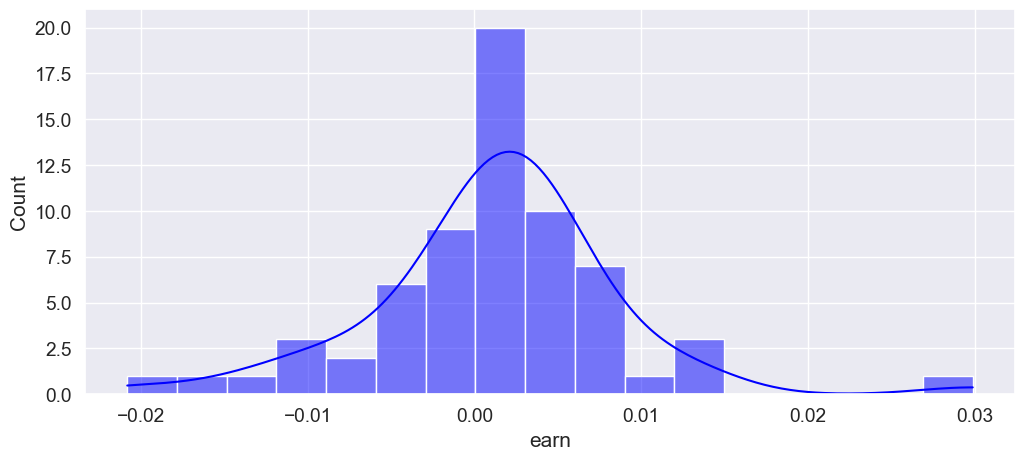

0.6439791961887281


In [111]:
trade_data['earn/dis'] = trade_data['earn'] / trade_data['dis_max']
# plt_box_A_B(trade_data, 'reason', 'earn', cut=False)
# plt_box_A_B(trade_data, 'reason', 'earn/dis', cut=False)

trade_idx = trade_data[is_trade_arr].index
# for idx in trade_idx:
#     print(f"{idx}: {milliseconds_to_date(full_data.loc[idx, 'open_time'])}")

histplot(trade_data.loc[trade_idx, 'earn'])
print(trade_data.loc[trade_idx, 'earn/dis'].mean())
# histplot(trade_data.loc[trade_idx, 'earn/dis'])


### 未来一段时间盈利的相关系数

In [75]:
heatmap_data = buy_break_data.copy()
target_step = 100
target.reset_target(target_step)

# base = 1
# target_name = f'{target_step}-{base}'
# heatmap_data[target_name] = heatmap_data[earn_name(target_step)] - heatmap_data[earn_name(base)]
# drop_other_steps(heatmap_data, base)

target_name = target.target_name()
target.drop_others(heatmap_data)
drop_col(heatmap_data, [max_win, min_win, imax_win, imin_win])
heatmap_font(heatmap_data, target=target_name)

In [ ]:
heatmap_data["index"] = heatmap_data.index
check_name, bias = ['histogram_TR', 0]
plt_A_B(heatmap_data, check_name, target_name)
plt_box_A_B(heatmap_data, check_name, target_name)
# heatmap_data[check_name+'_3cut'] = heatmap_data[check_name].apply(lambda x : 
#                                                             1 if x > 1.46e-5 else
#                                                             (-1 if x <-1.3e-6 else 0))
# plt_A_B(heatmap_data, check_name+'_3cut', target_name, cut=False)
# plt_box_A_B(heatmap_data, check_name+'_3cut', target_name, cut=False)
plt_A_B(heatmap_data, 'index', check_name, bias=bias)
plt_box_A_B(heatmap_data, 'index', check_name)
plt_A_B(heatmap_data, "index", target_name)

In [164]:
total_buy_bottom = len(buy_break_data)
for step in target.steps:
    print(f"{step}: earn rate: {sum(buy_break_data[target.name(step)] > 0) / total_buy_bottom * 100 :.2f} %, " + 
          f"mean of earn: {buy_break_data[target.name(step)].mean() * 100 :.2f}%")
    # histplot(buy_break_data[earn_name(step)])

1: earn rate: 47.07 %, mean of earn: 0.01%
3: earn rate: 41.21 %, mean of earn: -0.01%
5: earn rate: 43.10 %, mean of earn: -0.01%
10: earn rate: 42.93 %, mean of earn: -0.03%
30: earn rate: 45.69 %, mean of earn: -0.02%
100: earn rate: 46.55 %, mean of earn: -0.01%
300: earn rate: 46.72 %, mean of earn: -0.12%


In [ ]:
histplot(buy_break_data[target.name(300)])

# ML

## 获得训练集与测试集

In [ ]:
def split_data(full: pd.DataFrame, percentage=0.8, target_name='target'):
    # 特征列名
    category_col = [col for col in full if col != target_name]
    end_rows = int(full.shape[0] * percentage)

    x_train = full[category_col][:end_rows].values.astype(np.float64)
    y_train = full[target_name][:end_rows].values.astype(np.float64)

    x_test = full[category_col][end_rows:].values.astype(np.float64)
    y_test = full[target_name][end_rows:].values.astype(np.float64)

    return x_train, y_train, x_test, y_test

ML_data = buy_break_data.copy()
target.reset_target(10)
target.drop_others(ML_data)
x_train, y_train, x_test, y_test = split_data(ML_data, 0.5, target.target_name())

## xgb

In [ ]:
def xgb_predict(X_train, y_train, X_test, params=None, verbose_eval=100):
    
    if params == None:
        xgb_params = {'eta': 0.05, 'max_depth': 10, 'subsample': 0.8, 'colsample_bytree': 0.8, 
                  'objective': 'reg:linear', 'eval_metric': 'rmse', 'silent': True, 'nthread': 4}
    else:
        xgb_params = params

    folds = KFold(n_splits=10, shuffle=True, random_state=2023)
    oof_xgb = np.zeros(len(X_train))
    predictions_xgb = np.zeros(len(X_test))

    for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train, y_train)):
        if(verbose_eval):
            print("fold n°{}".format(fold_+1))
            print("len trn_idx  {}".format(len(trn_idx)))
            
        trn_data = xgb.DMatrix(X_train[trn_idx], y_train[trn_idx])
        val_data = xgb.DMatrix(X_train[val_idx], y_train[val_idx])

        watchlist = [(trn_data, 'train'), (val_data, 'valid_data')]
        clf = xgb.train(dtrain=trn_data,
                        num_boost_round=20000,
                        evals=watchlist,
                        early_stopping_rounds=200,
                        verbose_eval=verbose_eval,
                        params=xgb_params)
        
        
        oof_xgb[val_idx] = clf.predict(xgb.DMatrix(X_train[val_idx]), ntree_limit=clf.best_ntree_limit)
        predictions_xgb += clf.predict(xgb.DMatrix(X_test), ntree_limit=clf.best_ntree_limit) / folds.get_n_splits()

    if(verbose_eval):
        print("CV RMSE score: {:<8.8f}".format(sqrt(mean_squared_error(oof_xgb, y_train))))
    return oof_xgb, predictions_xgb

## lgb

In [ ]:
import lightgbm as lgb

def lgb_predict(X_train, y_train, X_test, params=None, verbose_eval=500):
    
    if params == None:
        lgb_param = {'num_leaves': 20, 'min_data_in_leaf': 2, 'objective':'regression', 'max_depth': 4,
         'learning_rate': 0.06, "min_child_samples": 2, "boosting": "gbdt", "feature_fraction": 1,
         "bagging_freq": 1, "bagging_fraction": 1, "bagging_seed": 11, "metric": 'rmse', "lambda_l2": 0.003,
         "verbosity": -1}
    else :
        lgb_param = params
        
    folds = KFold(n_splits=2, shuffle=True, random_state=2023)
    oof_lgb = np.zeros(len(X_train))
    predictions_lgb = np.zeros(len(X_test))

    for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train, y_train)):
        if verbose_eval:
            print("fold n°{}".format(fold_+1))
            
        trn_data = lgb.Dataset(X_train[trn_idx], y_train[trn_idx])
        val_data = lgb.Dataset(X_train[val_idx], y_train[val_idx])

        num_round = 50000
        clf = lgb.train(lgb_param, trn_data, num_round, valid_sets = [trn_data, val_data],
                        verbose_eval=verbose_eval, early_stopping_rounds = 100)
        
        oof_lgb[val_idx] = clf.predict(X_train[val_idx], num_iteration=clf.best_iteration)

        predictions_lgb += clf.predict(X_test, num_iteration=clf.best_iteration) / folds.get_n_splits()

    if verbose_eval:
        print("CV RMSE score: {:<8.8f}".format(sqrt(mean_squared_error(oof_lgb, y_train))))
    
    return oof_lgb, predictions_lgb

In [ ]:
# 假设我们有一个训练数据集 X_train，一个测试数据集 X_test
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(x_train)
# X_test_scaled = scaler.transform(x_test)

oof, predictions = xgb_predict(x_train, y_train, x_test, verbose_eval=5000)

print("-"*100, end="\n\n")
print("CV normal RMSE scores of predicting {} \nis {:<8.8f}".
        format(ML_data.columns, sqrt(mean_squared_error(predictions, y_test))))

In [ ]:
print(np.std(y_test))
pred_std, pred_mean = [np.std(predictions), np.mean(predictions)]
print(pred_std)
print(pred_mean)

In [ ]:
histplot(predictions)

In [ ]:
buy_i = [i for i in range(len(y_test)) if predictions[i] > 0.0004] 
sell_i = [i for i in range(len(y_test)) if predictions[i] < -0.0004]
print(len(buy_i))
print(len(sell_i))

In [ ]:
check_idx = sell_i
# print(check_idx)
# print(y_test[check_idx])
sum(y_test[check_idx]) / len(y_test)

# 结果可视化

## 预测与实际结果对应关系

+ __画 A 与 B 的统计图__

In [ ]:
test_df = ML_data.iloc[len(y_train):, :].copy()
test_df["predict"] = predictions

# idx_A, idx_B, bias=0.0, cut=True, cut_num=50
plt_A_B(test_df, target.target_name(), 'predict', 0, cut_num=10)
plt_A_B(test_df, 'predict', target.target_name(), 0, cut_num=10)
# test_df.head()

In [ ]:
show_data_basic_info(test_df)

+ __画 A 与 B 的箱体图__

In [ ]:
def plt_box_A_B(df_data, idx_A, idx_B):
    plt.figure(figsize=(18,5))
    sns.boxplot(x=idx_A, y=idx_B, data=df_data)
    sns.stripplot(x=idx_A, y=idx_B, data=df_data)
    plt.title(idx_B)
    plt.show()


# plt_box_A_B(test_df, target_name + '_cut', 'predict')
plt_A_B(test_df, 'is_up', target_name)

## 预测与实际结果分布关系

In [ ]:
import seaborn as sns

def result_plot(pred, truth):
    plt.figure(figsize=(12,5))
    sns.histplot(pred, kde=True, color="blue")
    # plt.title("Predict")
    # plt.xlabel('yield', fontsize=12)

    # plt.show()
    # plt.figure(figsize=(12,5))
    sns.histplot(truth, kde=True, color="red")
    # plt.title("Ground truth")
    plt.show()
    
result_plot(predictions_xgb, y_test)

In [ ]:
l = sum(y_test>0.01)
print(l)
s = sum(y_test<-0.01)
print(s)
print((l+s) / len(y_test))